# Modeling the scattering and the pulse profiles using shapelets in the time domain


In [1]:
from __future__ import print_function, division

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --user dynesty

import psrchive as p
import pylab
import scipy
from scipy.special import factorial
import numpy as np
import math
from multiprocessing import Pool
import dynesty
import os


In [3]:
class Scattering():
    def __init__(self, filename, nchan=2, incScatter=True, incScatter_index=False, Nshapelets=1):
    
        self.pDM = (1,500)
        self.pSc = (-6,-1) # en log -> 10-6 a 10-1 s a 1 GHz -> 1us a 100 ms.
        self.pSci = (-5,-2)
        self.incScatter = incScatter
        self.incScatter_index = incScatter_index
        self.reffreq = 1 # Reference frequency of 1 GHz
        self.nDM = 1
        self.nScatter = 1
        self.nfiles = 1
        
        self.set_data(filename, nchan)
        self.set_NShapelets(Nshapelets)

    def set_pDM(self, pDM):
        self.pDM = pDM
        
    def set_pSc(self, pSc):
        self.pSc = pSc
        
    def set_pSci(self, pSci):
        self.pSci = pSci
    
    def fft_rotate(self, arr, phase):
        """
        fft_rotate(arr, phase):  (Taken from PRESTO by Scott Ransom)
            Return array 'arr' rotated by 'phase' to the left.  The
                rotation is done in the Fourier domain using the Shift Theorem.
                'phase' is between 0 and 1.  The resulting vector will have
                the same length as the original.
        """
        arr = np.asarray(arr)
        freqs = np.arange(arr.size / 2 + 1, dtype=np.float)
        phasor = np.exp(complex(0.0, 2*np.pi) * freqs * phase)
        return np.fft.irfft(phasor * np.fft.rfft(arr), arr.size)
    
    def rotate(self, arr, phase):
        """                                                                         
        fft_rotate(arr, phase):                                                      
            Return array 'arr' rotated by "phase" to the left.  The           
                rotation is done using the Shift Theorem assuming arr is in freq domain.     
                'phase' is fractional between 0 and 1.  The resulting vector will have           
                the same length as the original.                                    
        """
        freqs = np.arange(arr.size, dtype=np.float)
        phasor = np.exp(complex(0.0, 2*np.pi) * freqs * phase)
        return arr * phasor

    def PBF(self, f, tau, nu, alpha):
        """
        Pulse broadening function(f, tau, nu, alpha):
            Return the Fourier pulse broadening function given by Lentati et al. (201?):
             - f: Fourier frequencies
             - tau: the scattering time scale
             - nu: the observing frequency
             - alpha: the scattering index
        """
        return 1/((2*np.pi*f*nu**alpha * 10**tau)**2 + 1) + 1j*(-2*np.pi*f*nu**alpha * 10**tau)/((2*np.pi*f*nu**alpha*10**tau)**2 +1)


    def set_NShapelets(self, Nmax):
        # Number of shapelets coefficients
        self.Nmax = Nmax - 1 # The first shapelet coefficient is set to 1 
        self.Scoeff = np.arange(self.Nmax + 1)
    
        # Construct array of Hermite polynomials
        self.hermit_ar = []
       
        for n in self.Scoeff:
            self.hermit_ar.append(scipy.special.hermite(n))
    
    def Prior(self, cube):
        pcube = np.zeros(cube.shape)
        ipar = 0
        
        # Shapelet width
        pcube[ipar] = 10**((cube[ipar]*3.5)-4) * self.period; ipar +=1
        
        # Shapelet profile phase phi0 (0->1)
        pcube[ipar:ipar+self.nfiles] = cube[ipar:ipar+self.nfiles]
        ipar += self.nfiles
        
        # Overall Shapelet scaling factor
        pcube[ipar:ipar+self.nchan] = 10**((cube[ipar:ipar+self.nchan]*1)-.5); ipar += self.nchan
        
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            pcube[ipar:ipar+self.nDM] = cube[ipar:ipar+self.nDM] * (self.pDM[1] - self.pDM[0]) + self.pDM[0]
            ipar += 1
            
        # Scattering time scale at XXX
        if self.incScatter:
            pcube[ipar:ipar+self.nScatter] = (cube[ipar:ipar+self.nScatter] * (self.pSc[1] - self.pSc[0]) + self.pSc[0])
            ipar += 1
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            pcube[ipar] = cube[ipar] * (self.pSci[1] - self.pSci[0]) + self.pSci[0]
            ipar += 1    
        
        # Shapelets amplitudes
        if self.Nmax:
            pcube[ipar:ipar+self.Nmax] = cube[ipar:ipar+self.Nmax]*40-20; ipar += self.Nmax

        # TODO: should add baseline offsets
            
        return pcube
        
    def set_data(self, filename, nchan=4):
        print(filename)
        self.prof = None
        self.wts = None
        self.period = None
        self.obsfreq = None
        self.prof_stds = None
        self.nbin = None
        self.data = None
        
        
        fn = filename
        try:
            arch = p.Archive_load(fn)
        except:
                raise
        self.nchan = nchan
        print("Tscrunching archive...")
        arch.tscrunch()
        print("Fscrunching archive to %d chans..."%nchan)
        arch.fscrunch_to_nchan(nchan)
        arch.pscrunch()
        arch.remove_baseline()
   
        integ = arch.get_first_Integration()
        
        # Get data
        self.data = arch.get_data()[0][0]
        maximums = np.max(self.data,axis=1)
        maximums = np.where(maximums==0, 1, maximums)
        
        # Get weights
        self.wts = arch.get_weights()[0]
        
        # Normalize the data
        self.prof = np.multiply(self.data.T, 1/maximums).T
        
        # Get pulsar's period
        self.period = integ.get_folding_period()
        
        # Get channel frequencies
        self.obsfreq = arch.get_frequencies()/1000.
        #print ("Frequencies:", self.obsfreq)
        
        # Get baseline RMS (1) for total intensity (0)
        stats = np.sqrt(integ.baseline_stats()[1][0])
        stats = np.where(stats==0, 1., stats)
        
        # Rescale the RMS due to normalization above
        self.prof_stds = stats/maximums
        
        # Get number of profile bins
        self.nbin = arch.get_nbin()
        
        # Create the time array (from -P/2 to +P/2)
        self.nu = np.arange(self.nbin, dtype=np.float) / self.nbin * self.period  - self.period/2.
        #print(self.prof, self.nu, self.prof_stds)    
        
    def plot_profiles(self):
        # Plot the data
        pylab.xlabel("Pulse phase (bins)")
        pylab.subplot(2, 1, 1)
        for ichan in range(self.nchan):
            pylab.plot((self.prof[ichan]+ichan))
        # Plot the model
        
        pylab.subplot(2, 1, 2)
        for ichan in range(self.nchan):
            pylab.plot((self.model[ichan]+ichan))
        pylab.savefig("profiles.pdf")    
        
    def shapelet_profile(self, Samp, width):
        
        nu_width = self.nu * width**-1
        
        # First shapelet has amplitude of 1
        n = 0
        model = 1 * width**-.5 * (np.power(2,n) * factorial(n) * np.pi**.5)**-.5 * self.hermit_ar[n](nu_width) * np.exp(-0.5 * nu_width*nu_width)
        
        #print (self.Scoeff, Samp)
        # TODO: we could remove the first coefficient from the parameters to sample
        for n in self.Scoeff[1:]:
            model += Samp[n-1] * width**-.5 * (np.power(2,n) * factorial(n) * np.pi**.5)**-.5 * self.hermit_ar[n](nu_width) * np.exp(-0.5 * nu_width*nu_width)
        return model

    def LogLikelihood(self, cube, DEBUG=False):
        ## ASSIGN VARIABLES ##
        ipar = 0
        width = cube[ipar]; ipar +=1
        
        phi0 = cube[ipar:ipar+self.nfiles]; ipar += self.nfiles
        
        Amp = cube[ipar:ipar+self.nchan]; ipar += self.nchan
        
        # include DM if more than one frequency channel in the model
        if self.nchan > 1:
            DM = cube[ipar:ipar+self.nDM]; ipar += self.nDM
            
        # Scattering time scale at XXX
        if self.incScatter:
            Tau = cube[ipar:ipar+self.nScatter]; ipar += self.nScatter
            
        # Scattering index 
        if self.nchan > 1 and self.incScatter and self.incScatter_index:
            Tau_index = cube[ipar]; ipar += 1
        else: Tau_index = -3.8
        
        # Shapelets amplitudes (for n>1)
        if self.Nmax:
            Samp = cube[ipar:ipar+self.Nmax]; ipar += self.Nmax
        else: Samp = np.array([]) 
            
            

        # Construct the profile model with Shapelets amplitude and widths. Todo: should add more than 1 Shapelet
        model = self.shapelet_profile(Samp, width)
 
        # FFT the model
        fftmodel_freqs = np.arange(model.size / 2 + 1, dtype=np.float) / ( self.period)
        self.fftmodel = np.fft.rfft(model)
        
        self.model = np.zeros((self.nchan, self.nbin))
    
        # For each channel, rotate given phase and dispersion, then scatter
        for ichan in range(self.nchan):
            # Discard any subband with zero weight
            if not self.wts[ichan]:
                continue
            
            # Get the DM delay phase (fractional part of the DM delay/period )
            if nchan > 1:
                delay_phase = math.modf(DM * 4.14879e-3 * (1/self.obsfreq[ichan]**2 - 1/self.reffreq**2 ) / self.period)[0];
            else: delay_phase = 0
            
            # Apply DM delay to phase offset
            #print(self.obsfreq[ichan], delay_phase, DM * 4.14879e-3 * (1/self.obsfreq[ichan]**2 - 1/self.reffreq**2 ) / self.period)
            phase_off = phi0-delay_phase
            while phase_off < 0:
                phase_off += 1
                
            # Rotate
            ifftmodel = self.rotate(self.fftmodel, phase_off)
        
            # Scatter the model
            if self.incScatter:
                ifftmodel *= self.PBF(fftmodel_freqs, Tau, self.obsfreq[ichan], Tau_index)
        
            # FFT back the model for each channel
            self.model[ichan] = np.fft.irfft(ifftmodel, model.size)
            self.model[ichan] /= np.max(self.model[ichan])

        # Apply overall scaling factor
        #print (self.model.shape, Amp.shape)
        self.model = (self.model.T * Amp).T
        
        self.modelc = self.model.T
            
        self.profc = self.prof.T         

        chi = np.sum((self.modelc-self.profc)**2/self.prof_stds**2)
        
        return -0.5 * chi
             


In [19]:
### THIS IS THE ONLY CELL WHERE WE SET THE PARAMETERS ###

# Set the number of shapelets (1 is basically a gaussian)
Nshapelets = 1

# Set the number of channels
nchan = 4

# Set the location of the filename
#filename = "/Users/gdesvignes/nsub16/2205.ar.T"
filename = "/Volumes/DATASSD/2205+6015/Nancay/data/nuppi_59010_2205+6015_257963.dm3"

# Set the prior for DM
DMr = (157.61,157.67)

# Set the prior for the scattering time scale at 1 GHz in s, in log unit
Tau_sc = (-4,-2.)

# Set the prior for scattering index
Tau_idx = (-5,-2)

# Fit for scattering? 
incScatter = True

# Fit for scattering index?
incScatter_index = False




In [20]:
# RUN THE ANALYSIS
Ndim = 1 + 1 + nchan + (Nshapelets-1)
if nchan > 1:
    Ndim += 1
if incScatter == True:
    Ndim += 1
if incScatter_index == True:
    Ndim += 1
print("Ndim = %d\n"%Ndim)

print(filename)
model = Scattering(filename, nchan=nchan, Nshapelets=Nshapelets, incScatter=incScatter)

# Set the DM prior                                                                                                                                                                                
model.set_pDM(DMr)

# Set the prior for the scattering time scale at 1 GHz, in log unit                                                                                                                               
model.set_pSc(Tau_sc)


Ndim = 8

/Volumes/DATASSD/2205+6015/Nancay/data/nuppi_59010_2205+6015_257963.dm3
/Volumes/DATASSD/2205+6015/Nancay/data/nuppi_59010_2205+6015_257963.dm3
Tscrunching archive...
Fscrunching archive to 4 chans...


In [21]:
sampler = dynesty.NestedSampler(model.LogLikelihood, model.Prior, Ndim, nlive=200)
sampler.run_nested()

5774it [00:41, 137.63it/s, +200 | bound: 90 | nc: 1 | ncall: 34646 | eff(%): 17.243 | loglstar:   -inf < -4076.715 <    inf | logz: -4103.940 +/-  0.504 | dlogz:  0.001 >  0.209]


In [23]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

dresults = sampler.results

# Extract sampling results.
samples = dresults.samples  # samples
weights = np.exp(dresults.logwt - dresults.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.5, 0.15832, 1-0.15832], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(dresults)

In [32]:
print ("DM, pc cm^-3 :" , quantiles[2+nchan][0], -quantiles[2+nchan][0] + quantiles[2+nchan][1], quantiles[2+nchan][2] - quantiles[2+nchan][0])
print ("Scatt time @1GHz, seconds: ", 10**quantiles[3+nchan][0], -10**(quantiles[3+nchan][0]) + 10**(quantiles[3+nchan][1]), 10**(quantiles[3+nchan][2]) - 10**(quantiles[3+nchan][1]))

DM, pc cm^-3 : 157.63334584466352 -0.002783765894434964 0.002704823583229654
Scatt time @1GHz, seconds:  0.0004029671995245977 -1.6765092961918185e-05 3.381285391255908e-05


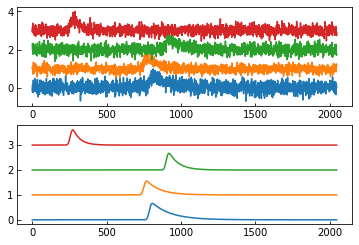

In [26]:
model.plot_profiles()

In [33]:
#quantiles

In [24]:
cfig.savefig("corner.pdf")

In [ ]:
[-3.4557840842874676, -3.47688540350335, -3.433885406236238]]